# Loan Approval Prediction

In [1]:
# Libraries import 


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import joblib


In [2]:
# Load dataset


df = pd.read_csv("loan_approval_dataset.csv")
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [3]:
# Column Cleaning

df.columns = df.columns.astype(str).str.strip().str.lower().str.replace(" ", "_")
df.columns

Index(['loan_id', 'no_of_dependents', 'education', 'self_employed',
       'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
       'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value', 'loan_status'],
      dtype='object')

In [4]:
# CLEAN loan_status (convert to 0/1)


def clean_status(v):
    v = str(v).strip().lower()
    return 1 if v in ["approved", "approve", "1", "yes", "true", "y"] else 0

df["loan_status"] = df["loan_status"].apply(clean_status)
df["loan_status"].value_counts()

loan_status
1    2656
0    1613
Name: count, dtype: int64

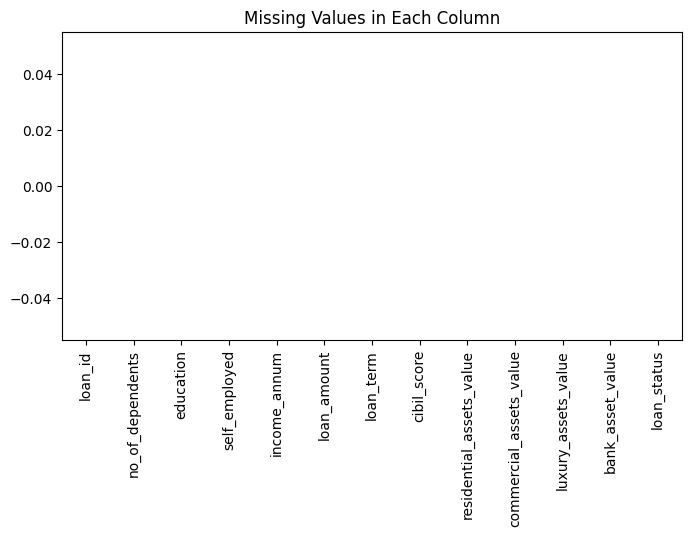

In [5]:
# EDA: Missing Values
plt.figure(figsize=(8,4))
df.isna().sum().plot(kind="bar")
plt.title("Missing Values in Each Column")
plt.show()

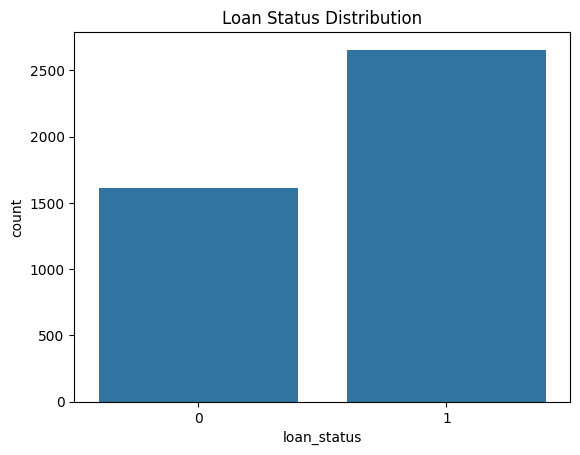

In [6]:
# EDA: Target Distribution
sns.countplot(x=df["loan_status"])
plt.title("Loan Status Distribution")
plt.show()

In [7]:
# NUMERIC & CATEGORICAL COLUMNS

numeric_cols = [
    'no_of_dependents','income_annum','loan_amount','loan_term',
    'cibil_score','residential_assets_value','commercial_assets_value',
    'luxury_assets_value','bank_asset_value'
]

categorical_cols = ['education','self_employed']

# Ab X aur y bana rahe hain
X = df.drop(columns=["loan_status","loan_id"], errors="ignore")
y = df["loan_status"]

X.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000
4,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000


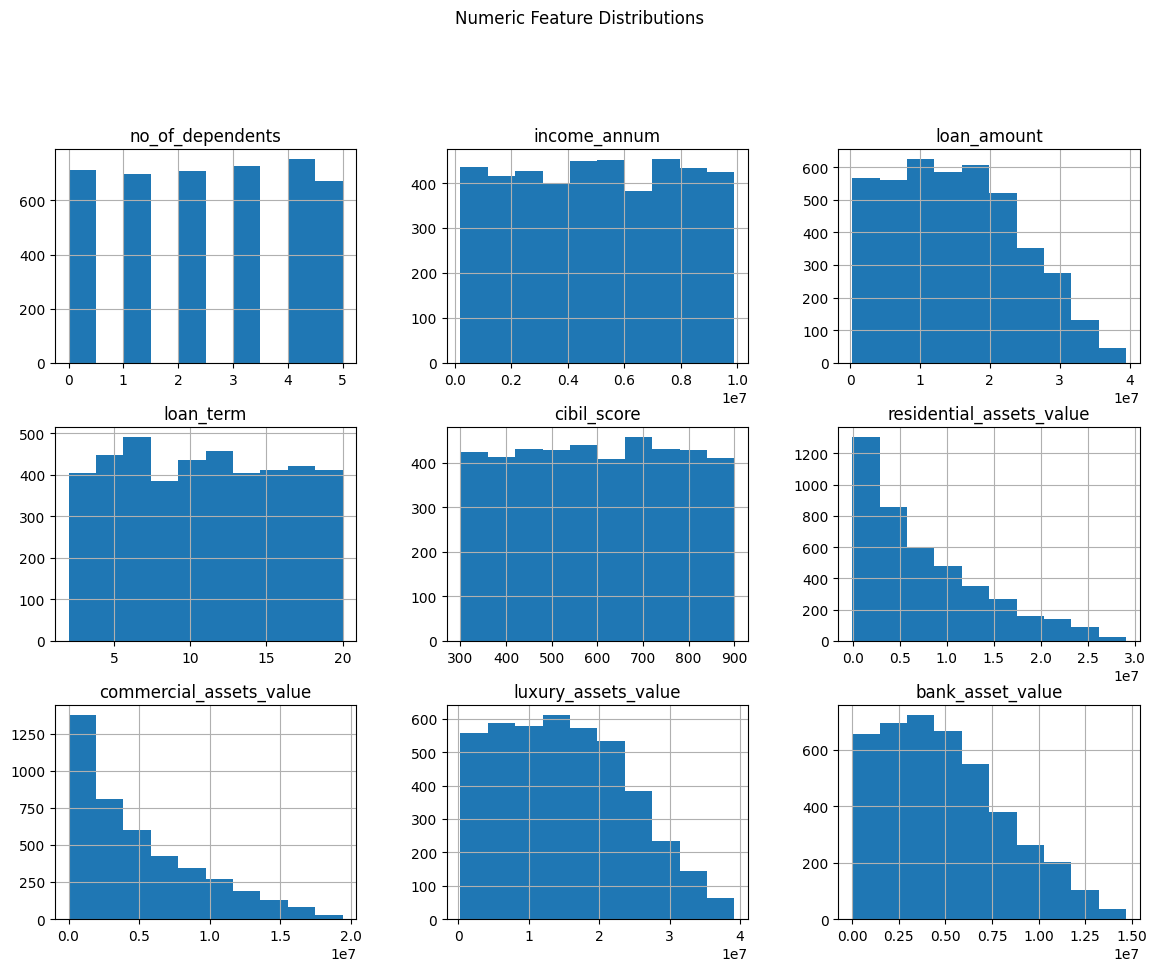

In [8]:
# EDA: Numeric Histograms
df[numeric_cols].hist(figsize=(14,10))
plt.suptitle("Numeric Feature Distributions", y=1.02)
plt.show()

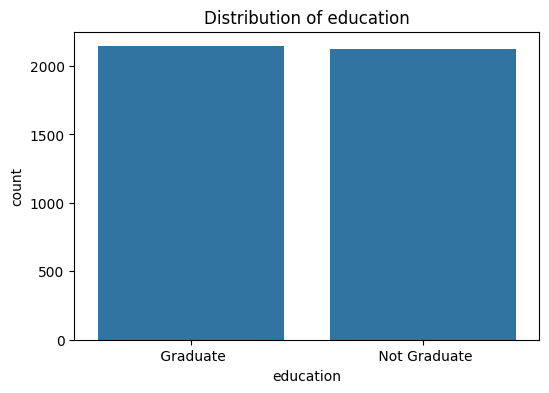

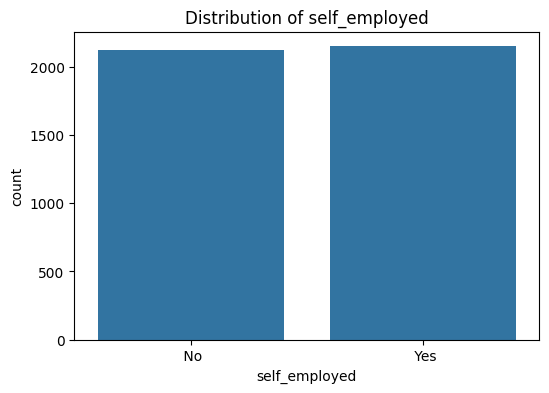

In [9]:
# Categorical Charts
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=df[col])
    plt.title(f"Distribution of {col}")
    plt.show()

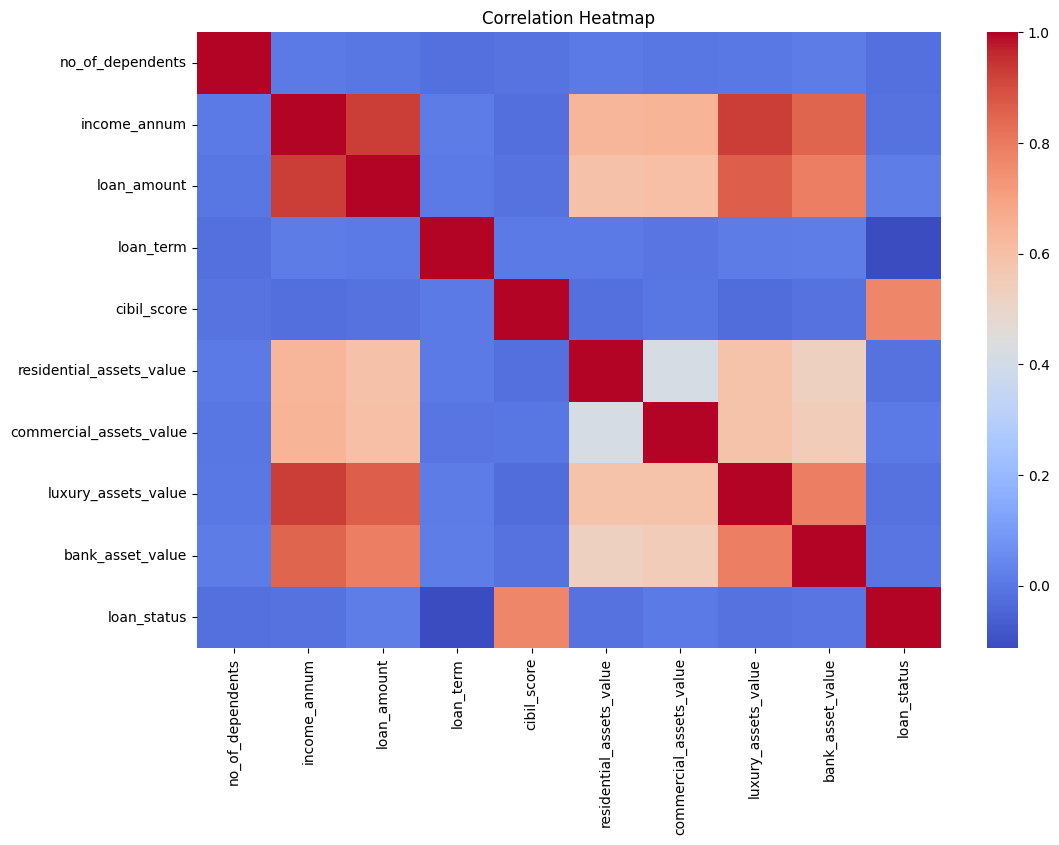

In [10]:
# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_cols + ["loan_status"]].corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [11]:
# Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((3415, 11), (854, 11))

In [12]:
#  Preprocessing setup
numeric_transform = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transform = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transform, numeric_cols),
    ("cat", categorical_transform, categorical_cols)
])


In [14]:
# Model training
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

trained_models = {}
results = []

for name, model in models.items():
    print(f"\n--- Training: {name} ---\n")
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(classification_report(y_test, y_pred))

    trained_models[name] = pipe
    results.append([name, acc, prec, rec, f1])



--- Training: Logistic Regression ---

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       323
           1       0.92      0.94      0.93       531

    accuracy                           0.91       854
   macro avg       0.91      0.91      0.91       854
weighted avg       0.91      0.91      0.91       854


--- Training: Random Forest ---

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       323
           1       0.98      0.98      0.98       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854


--- Training: Gradient Boosting ---

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       323
           1       0.98      0.99      0.99       531

    accuracy                           0.98       854
   macro avg    

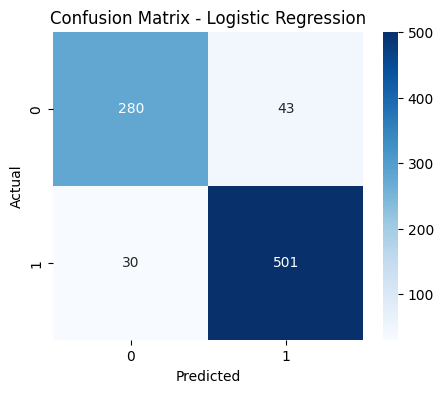

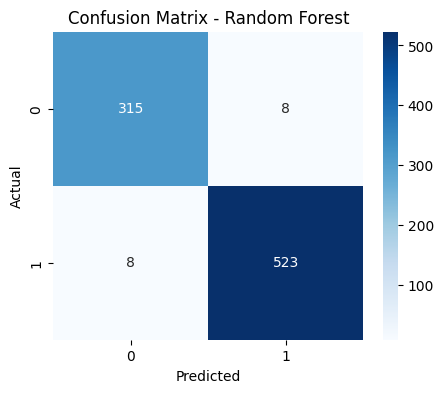

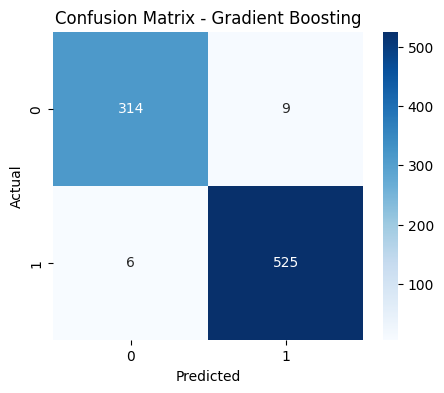

In [15]:
# Confusion Matrices
for name, model in trained_models.items():
    plt.figure(figsize=(5,4))
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

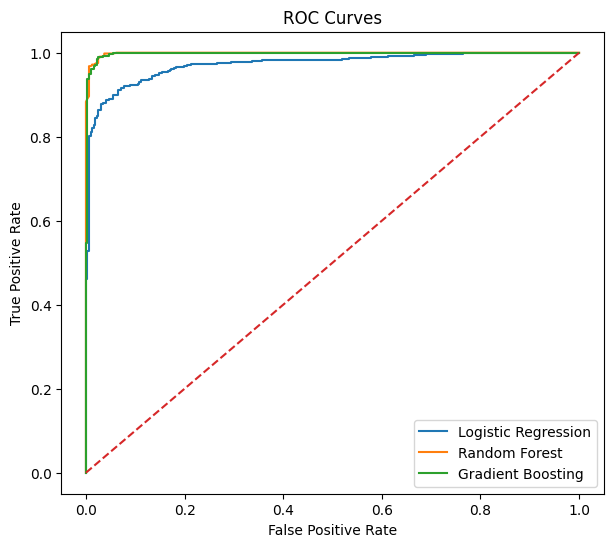

In [16]:
#  ROC Curves
plt.figure(figsize=(7,6))

for name, model in trained_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=name)

plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

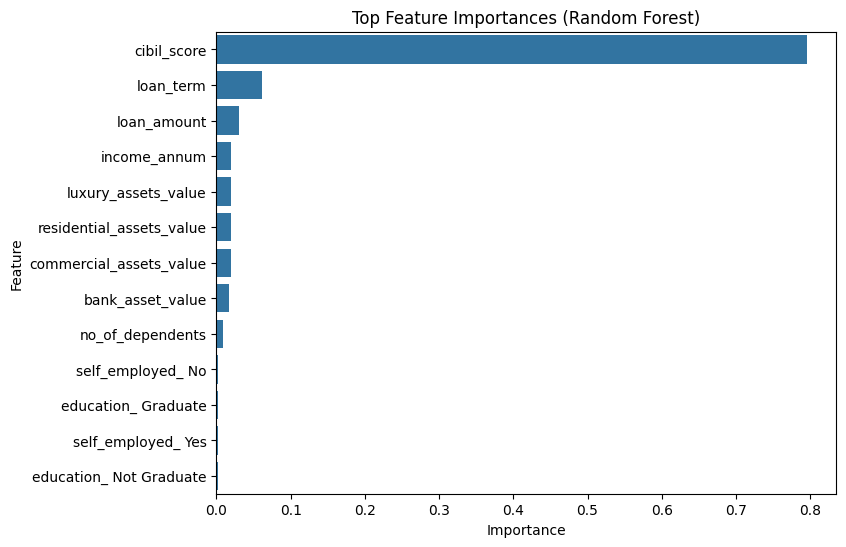

In [21]:
# Random Forest model retrieve
rf = trained_models["Random Forest"]

# Preprocessor fit for feature names
preprocess.fit(X_train)

# All final feature names
num_features = numeric_cols
cat_features = list(preprocess.named_transformers_['cat']
                    .named_steps['onehot']
                    .get_feature_names_out(categorical_cols))

final_features = num_features + cat_features

# Importance values
importances = rf.named_steps["model"].feature_importances_

# Making DataFrame
fi = pd.DataFrame({
    "Feature": final_features,
    "Importance": importances
})

fi = fi.sort_values("Importance", ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=fi)
plt.title("Top Feature Importances (Random Forest)")
plt.show()


In [22]:
# Results 
res_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1"])
res_df.sort_values("F1", ascending=False)

,Model,Accuracy,Precision,Recall,F1
2,Gradient Boosting,0.982436,0.983146,0.988701,0.985915
1,Random Forest,0.981265,0.984934,0.984934,0.984934
0,Logistic Regression,0.914520,0.920956,0.943503,0.932093


In [24]:
# Save final model locally ---
final_model_name = res_df.sort_values("F1", ascending=False).iloc[0]["Model"]
final_model = trained_models[final_model_name]

joblib.dump(final_model, "loan_approval_model.pkl")
res_df.to_csv("loan_approval_results.csv", index=False)

print("Final Model Saved:", final_model_name)


Final Model Saved: Gradient Boosting
